# Data-driven material parameter estimation

## Use case and problem statement

* The **noDataScienceCompany** is excellent in technical simulations
* They are performing measurements in the lab regarding the diffusion in fluids (concentration, time, place)
* With known material parameters and initial conditions, the **noDataScienceCompany** is able to simulate the measurements with high accuracy


### Problem
* The simulations are very complicated and therefore time-consuming
* The fitting process needs to be done very often
* Each prediction is an iterative optimization problem

<img src="fig/flowchart-black-box-model.png" width="300" align="center"/>

### Solution
* The Data Science team from the **cellent GmbH** understands the problem and supposes a data-driven solution
* Feeding labeled training data to ML model
* Trained model can be reused for future predictions

### Model requirements
The trained model should predict the material parameters, while the following requirements should be addressed through the implementation:

* noise in experimental data should be accounted for,
* data points in experimental data is often unevenly distributed,

## Classical parameter optimization

*  The reconstruction of material parameters from experiments or simulations is an intensively-studied optimization problem
*  It can be formulated as a regression problem
*  The output is related through a model to it's input values
*  Minimization of a cost function leads to the best fit parameters

<center><img src="fig/flowchart-parameter-optimization.png" width="500" /><\center>

### Example of a linear regression

In case of a simple analytical relation between the input and output, a parameter estimation is usually carried out by curve fitting (regression). 

<center><img src="fig/example-regression.png" width="800" align="center"/><\center>

## Data-driven parameter estimation

* The implemented machine learning models learn the mapping between input and output through training data. 
* Herein, each training sample consists of (vector-valued) **features**, which are mapped to the corresponding **labels**

In the case of the stress-strain curve, features and labels are given by:

*   features (vector-valued): $\varepsilon$, $\sigma$
*   label(s): $E$ 

Note that the labels represent the target of a prediction, while the data generation process will be explained later. Note that in the case of multiple parameters, the machine learning task is  consequently classified as a **multi-target regression**.

### Solution procedure

* Analyze an exemplary experiment.
* Generating apropriate test and train data.
* Implement a machine learning model.
* Training the model and optimize hyperparameter.
* Evaluate the generalization performance on the test data.

<center><img src="fig/flowchart-parameter-optimization-ml.png" width="800" align="center"/><\center>

# Setup

In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import itertools
import os
from scipy import stats
from scipy import constants
from scipy.integrate import odeint
from scipy.optimize import curve_fit

# custom functions for plotting
from plotstandards import *
from plotlabels import PlotLabels

## Custom plot style

In [6]:
# set custom matplotlib rc file 
url_rcfile = 'https://raw.githubusercontent.com/TheFerry10/ml-parameter-identification/master/seaborn-custom-style.mplstyle'
#path_rcfile = 'seaborn-custom-style.mplstyle'
mpl.style.use(url_rcfile)

# Uncomment the following lines, if you wish to use latex fonts in matplotlib
# figures. The first line installs latex fonts, while the second line activates
# the fonts in the matplotlib rc file

#!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng
mpl.rcParams['text.usetex'] = True

plotStyle = CustomPlotStyle(textwidth_in_inches=12.0)
plotLabels = PlotLabels()

PATH_TO_FIGURES = 'fig/'
if not os.path.isdir(PATH_TO_FIGURES):
    os.mkdir(PATH_TO_FIGURES)
    
sns.set_context(context='talk', font_scale=1.4)

## Analytical model

For simplification, the simulation is here represented through the following *ordinary differential equation* (ODE)
\begin{equation}
\frac{\rm{d}c}{\rm{d}t} = -k c \quad
\text{with} \quad
c(t=0) = c_0\,.
\end{equation}
The targets are the initial concentration $c_0$ and the kinetic constant $k$.

In [7]:
fit_parameter_names = ['c_0', 'k']

### Specify model

In [8]:
def ode_model(c , t, k):
    dcdt =  -k * c 
    return dcdt
  
def get_output_from_model(t, c_0, k):
    """
    Implementation of the desired model.
    This could be very complex. However,
    for illustration of the method,
    a simple approach is followed.
    """
    # solve ODE
    param = (k,)
    y = odeint(ode_model, c_0, t, args=param)
    return y.squeeze()

### Helper functions

In [9]:
def create_dict_from_keys_and_values(values, keys=fit_parameter_names):
    return dict(zip(keys, values))

def create_plot_label_from_dict(dct):
    label = ''
    for key, value in dct.items():
        label += '${} = {:.3f}$, '.format(key, value)
    return label[:-2]

def get_normal_distributed_noise(num_elements, sigma):
    noise = np.random.normal(0, sigma, num_elements)
    return noise

 # Exploratory data analysis 

In [10]:
# create pseudo experimental data
c_0, k = 1.0, 1e-1
t = np.linspace(0,60,100)
df_experiment = pd.DataFrame()
df_experiment["time"] = t
df_experiment["concentration"] = get_output_from_model(t, c_0, k) + get_normal_distributed_noise(len(t), 0.05)
df_experiment.head()

,time,concentration
0,0.000000,0.989382
1,0.606061,0.860808
2,1.212121,0.906338
3,1.818182,0.864686
4,2.424242,0.757170


In [11]:
num_datapoints, num_vars  = df_experiment.shape

The rolling mean and standard deviation corresponding corresponding to a fixed window size are calculated from the data. The averaged standard deviation will be later used to generate stress-strain curves, which obtain similar signal-to-noise values in the stress. 

In [12]:
window = int(0.05 * len(t))
num_std = 1
df_experiment["rollingMean"] = df_experiment["concentration"].rolling(window).mean()
df_experiment["rollingStd"] = df_experiment["concentration"].rolling(window).std()
std_estimated_from_experiments = df_experiment["rollingStd"].mean()
print("Estimated averaged standard deviation:", std_estimated_from_experiments)

Estimated averaged standard deviation: 0.04795221487551347


The stress-strain curve is visualized together with the rolling mean and error bands:

In [13]:
df_experiment["lowErrorBand"] = df_experiment["rollingMean"] - num_std * std_estimated_from_experiments
df_experiment["highErrorBand"] = df_experiment["rollingMean"] + num_std * std_estimated_from_experiments

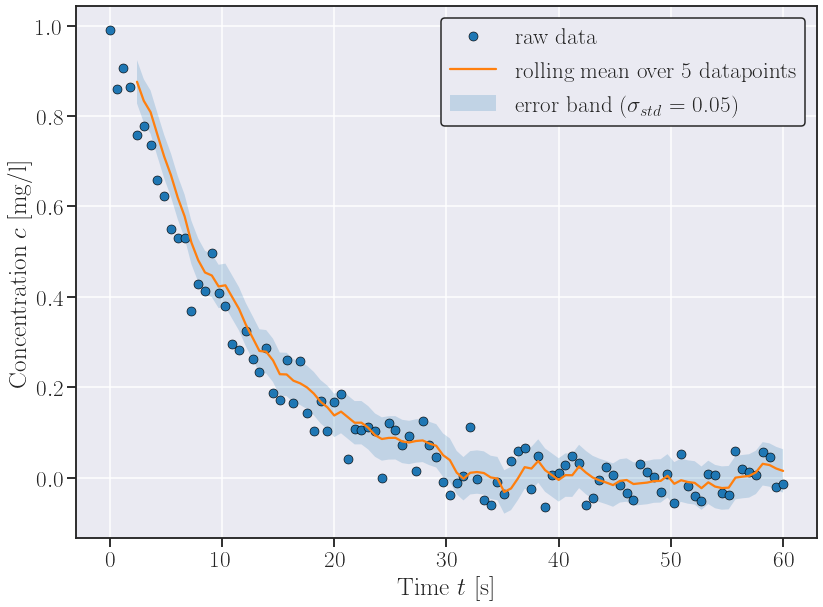

In [14]:
fig, ax = plotStyle.create_figure()
plt.plot("time", "concentration", data=df_experiment, label='raw data', marker='o', linewidth=0)
plt.plot("time", "rollingMean", data=df_experiment, label=f'rolling mean over {window} datapoints')
plt.fill_between(x="time", y1="highErrorBand", y2="lowErrorBand", data=df_experiment, alpha=0.2,
                 label='error band ($\sigma_{std}$' + ' = {:.2f})'.format(std_estimated_from_experiments))
plt.xlabel(plotLabels.time)
plt.ylabel(plotLabels.concentration)
plt.legend();
save_fig('compare-raw-data-rolling-mean',PATH_TO_FIGURES)

## Fitting the raw data (the classical method)
A non-linear least square method is used to fit the model, ``get_output_from_model``, to the experimental data ``df_experiment``. The optimization routine is implemented in the scientific computing libary Scipy. 

In [15]:
parameter_values_from_curve_fit, cov_values_from_curve_fit = curve_fit(get_output_from_model, df_experiment['time'], df_experiment['concentration'], p0=np.ones(len(fit_parameter_names)))

``pcov`` denotes the estimated covariance of the optimized parameters, ``popt``, while the elements on the diagonal provide the variances. To compute the standard deviation of the parameters, ``perr``, use: 

In [16]:
err_values_from_curve_fit = np.sqrt(np.diag(cov_values_from_curve_fit))

opt_parameters_from_curve_fit = create_dict_from_keys_and_values(parameter_values_from_curve_fit)
err_from_curve_fit = create_dict_from_keys_and_values(err_values_from_curve_fit)

In [17]:
# set plot label and save name
plot_label_least_squares = r'least squares fit ('
plot_label_least_squares += create_plot_label_from_dict(opt_parameters_from_curve_fit) + ')'

plot_parameters_least_squares = {'label': plot_label_least_squares,
                                 'save_name': "compare-data-to-least-square-fit"}                       

In [18]:
def plot_raw_data_and_analytic_model(opt_parameters, **plot_parameters):
    fig, ax = plotStyle.create_figure()
    plt.plot("time", "concentration", data=df_experiment, label='raw data from experiments', marker='o', linewidth=0)
    plt.plot(df_experiment["time"], get_output_from_model(df_experiment["time"], **opt_parameters), label=plot_parameters_least_squares['label'])
    plt.legend()
    plt.xlabel(plotLabels.time)
    plt.ylabel(plotLabels.concentration)
    if plot_parameters['save_name'] != '':
        save_fig(plot_parameters['save_name'], PATH_TO_FIGURES)

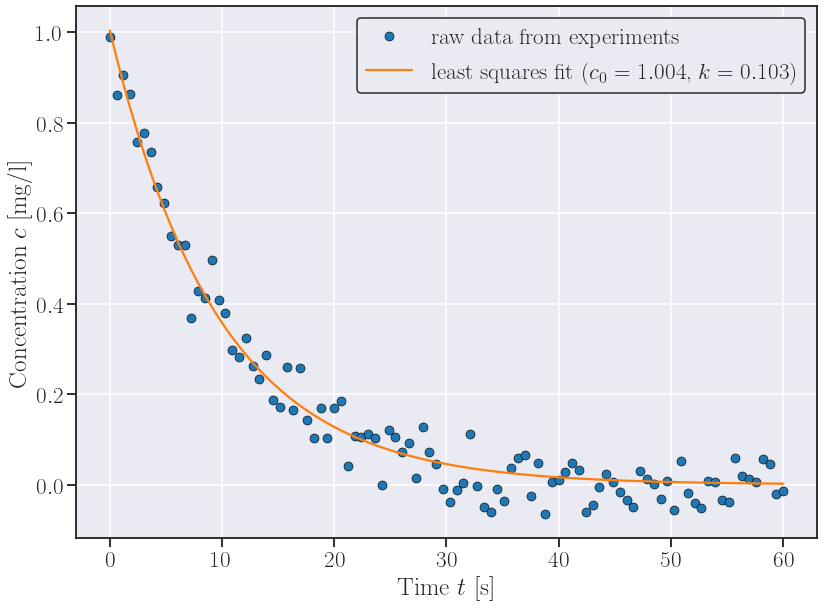

In [19]:
plot_raw_data_and_analytic_model(opt_parameters_from_curve_fit, **plot_parameters_least_squares)

# Data generation

A data generator is implemented to obtain stress-strain curves. To this end, the analytical model is used to produce concentration values corresponding to the input values, namely, a given time vector as well as the model parameters $c_0$ and $k$. In addition, Gaussian distributed noise is added to the analytically computed output, while the standard deviation of the randomly added noise is chosen in accordance to the exemplary curve, i.e. the average rolling standard deviation ``std_estimated_from_experiments``. 
Each training data sample contains the time and corresponding concentration vectors as features, while the parameters for the generation, i.e. $c_0$ and $k$, are saved as targets (labels). 

The data generator is finally used to generate samples for various $c_0$ and $k$ value pairs. The $c_0$ and $k$ values are picked from uniform distributions in the range of $[c_{0,{min}}, c_{0,{max}}]$ and $[k_{min}, k_{max}]$, respectively. The number of datapoints is contant above all generated samples, however, the entries for the input vector $t$ are randomly distributed (uniform distribution) between $t_{min}$ and $t_{max}$. As a results, training a model with such randomized data should lead to an enhanced generalization performance and therefore a flexible use of the final model.  

In [20]:
class ConcentrationEvolutionDataGenerator(object):
    '''
    A flexible data generator, which produces a desired amount of 
    labled data. 
    The features are the concentration and time, while the
    lables (targets) are the set of fitting parameters
    '''
    def __init__(self, num_datapoints=100, t_min=0.0, t_max=60.0):
        self.num_datapoints = num_datapoints
        self.t_min = t_min 
        self.t_max = t_max
        self.std_noise = 0.0

    def get_concentration(self, c_0, k, add_noise=False, constant_distant_between_datapoints=True):
        if constant_distant_between_datapoints:
            t = np.linspace(self.t_min, self.t_max, self.num_datapoints)
        else:
            t = np.random.uniform(self.t_min, self.t_max, self.num_datapoints)
            t = np.sort(t)
        c =  get_output_from_model(t, c_0, k)
        if add_noise:
            c += self.get_noise(len(t), self.std_noise)       
        return np.array([t, c]) 

    def shuffle_datasets(self, data, labels):
        shuffle_index = np.random.permutation(len(labels))
        return data[shuffle_index], labels[shuffle_index]

    def get_noise(self, num_elements, sigma):
        noise = np.random.normal(0, sigma, num_elements)
        return noise        

    def generate_datasets(self, num_samples=100, c_0_range=[0,2], k_range=[1e-2,100e-2], shuffle=True, add_noise=True, constant_distant_between_datapoints=False):
        generated_time_concentration_list = []
        generated_parameters_list = []
        for index_sample in range(num_samples):
                c_0 = np.random.uniform(c_0_range[0],c_0_range[1])
                k = np.random.uniform(k_range[0],k_range[1])
                generated_time_concentration = self.get_concentration(c_0, k, add_noise, constant_distant_between_datapoints)
                generated_time_concentration_list.append(generated_time_concentration)
                generated_parameters_list.append(np.array([c_0, k]))
        data = np.array(generated_time_concentration_list)
        targets = np.array(generated_parameters_list) 
        if shuffle:
            return self.shuffle_datasets(data, targets)  
        else:            
            return data, targets  

In [21]:
# The number of datapoints corresponds to the data set, which needs to be predicted.
concentrationEvolutionDataGenerator = ConcentrationEvolutionDataGenerator(num_datapoints=num_datapoints, t_min=0, t_max=60) 
concentrationEvolutionDataGenerator.std_noise =  std_estimated_from_experiments 
curves, targets = concentrationEvolutionDataGenerator.generate_datasets(num_samples=1000,
                                                                        c_0_range=[0.5,2],
                                                                        k_range=[1e-2,20e-2],
                                                                        shuffle=True,
                                                                        add_noise=True,
                                                                        constant_distant_between_datapoints=False)

Now some of the generated curves can be plotted. Note that the amount of plotted curves is restricted here to only a very few.

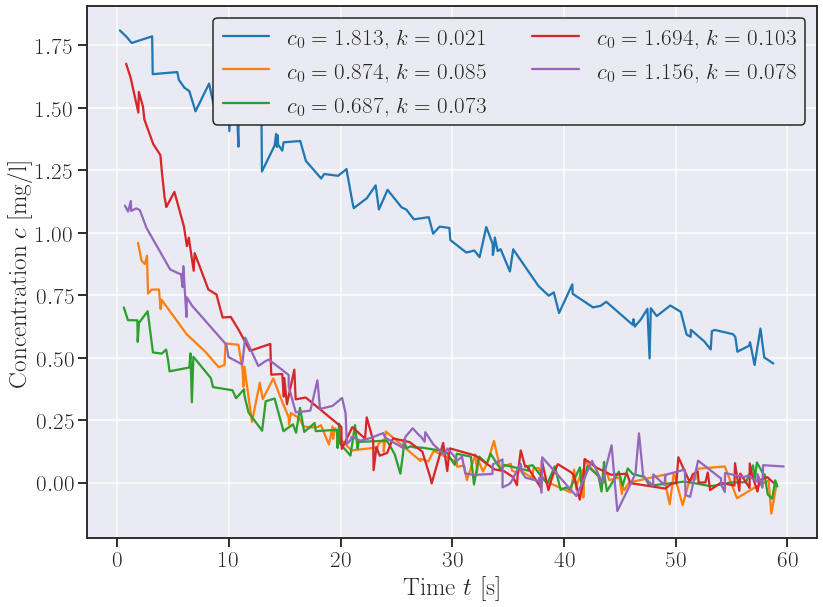

In [24]:
fig, ax = plotStyle.create_figure()
num_plotted_curves = 5
for sample_index in range(0, num_plotted_curves):
    x = curves[sample_index][0]
    y = curves[sample_index][1]
    label = create_plot_label_from_dict(create_dict_from_keys_and_values(targets[sample_index]))
    plt.plot(x, y, label=label)
plt.xlabel(plotLabels.time)
plt.ylabel(plotLabels.concentration)
plt.legend(ncol=2);
#save_fig("sample-generated-curves", PATH_TO_FIGURES)

# Machine learning models

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, StackingRegressor, VotingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error

With the generated data it is very easy to split it to training and testing samples.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(curves, targets, test_size=0.2)

In [27]:
X_train.shape

(800, 2, 100)

In [28]:
X_train[0,:,:]

array([[ 8.74570492e-01,  9.75628980e-01,  1.09216450e+00,
         1.24455941e+00,  1.29561201e+00,  3.12743424e+00,
         3.56411121e+00,  4.53467097e+00,  5.58675415e+00,
         6.79927517e+00,  6.85738436e+00,  7.07291953e+00,
         8.00933098e+00,  8.23697269e+00,  8.71398284e+00,
         8.99824793e+00,  9.35771411e+00,  9.69600214e+00,
         9.74696510e+00,  1.12131320e+01,  1.16139570e+01,
         1.31671086e+01,  1.35877040e+01,  1.39547894e+01,
         1.51371115e+01,  1.56672049e+01,  1.60824658e+01,
         1.65062514e+01,  1.72609997e+01,  1.79988703e+01,
         1.85223743e+01,  1.94834621e+01,  1.96147175e+01,
         2.05206905e+01,  2.06953563e+01,  2.25098006e+01,
         2.27178961e+01,  2.36110816e+01,  2.48989188e+01,
         2.54167481e+01,  2.58987798e+01,  2.81328977e+01,
         2.81682717e+01,  2.91970043e+01,  2.94103305e+01,
         2.95818292e+01,  2.98484667e+01,  3.01679655e+01,
         3.11770416e+01,  3.13389383e+01,  3.28479462e+0

The generated training data do not have the right shape for the further use in the machine learning models. To this end, the ``DataTransformer`` is intoduced to reshape the data into the compatible shape, i.e. ``(num_samples, num_variables*num_datapoints)``.  

In [29]:
class DataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        num_samples, num_variables, datapoints = X.shape
        X = X.reshape((num_samples, num_variables * datapoints))
        return X

Before the data is passed to a specific estimator, data transformations are carried out. First, the data is transformed using the ``DataTransformer``, while in a second step, the reshaped data is passed to a scaling function. For convenience, both steps are combined by defining apropriate pipelines. Finally, the data transformation pipeline is merged into a new pipeline, where the preprocessed data is now given to the specified estimator. 
Here, two distinct numeric transformers are defined to compare their performance during the hyperparameter optimization. 

For further information on pipelines in combination with hyperparameter optimization, check out the following project: 
https://www.kaggle.com/pedrodematos/titanic-a-complete-approach-to-top-6-rank

In [30]:
numeric_transformer_1 = Pipeline(steps=[('transform', DataTransformer()),
                                        ('scaler', MinMaxScaler())])

numeric_transformer_2 = Pipeline(steps=[('transform', DataTransformer()),
                                        ('scaler', StandardScaler())])

# Initializing data transformation step by choosing any of the above.
# Initializing modeling step of the pipeline with any model object.
pipe = Pipeline(steps=[('numeric_transformations', numeric_transformer_1), 
                       ('reg', RandomForestRegressor())]) 

## Train models and optimize hyperparameters

In the following, a predefined amount of hyperparameters are optimized through the Scikit-Learn class ``RandomSearchCV``. The parameter space is given by the following set:  

In [64]:
# grid search parameters:
params_distributions = [{'numeric_transformations': [numeric_transformer_1, numeric_transformer_2],
                         'reg': [RandomForestRegressor()],
                         'reg__n_estimators': stats.randint(10, 300),
                         'reg__criterion': ['mse']},
               
                        {'numeric_transformations': [numeric_transformer_1, numeric_transformer_2],
                         'reg': [MultiOutputRegressor(SVR())],
                         'reg__estimator__kernel': ['linear','rbf'],
                         'reg__estimator__C': stats.uniform(loc=1, scale=9)}]              

In [65]:
best_model_pipeline = RandomizedSearchCV(pipe, params_distributions, n_iter=50, 
                                         n_jobs=-1, cv=5, random_state=42,
                                         scoring='neg_mean_squared_error',
                                         verbose=1)

Finally, the estimators are fitted to the training data, while the hyperparameters are optimized through the random search algorithm.

In [66]:
best_model_pipeline.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  4.3min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('numeric_transformations',
                                              Pipeline(steps=[('transform',
                                                               DataTransformer()),
                                                              ('scaler',
                                                               MinMaxScaler())])),
                                             ('reg', RandomForestRegressor())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions=[{'numeric_transformations': [Pipeline(steps=[('transform',
                                                                                      DataTransformer()),
                                                                                     ('scaler',
                                                                                      MinMaxScaler())]),
                                                           

The results of the best model found by the random search read:

In [35]:
print("\n\n#---------------- Best Data Pipeline found in RandomSearchCV  ----------------#\n\n", best_model_pipeline.best_estimator_[0])
print("\n\n#---------------- Best Regressor found in RandomSearchCV  ----------------#\n\n", best_model_pipeline.best_estimator_[1])
print("\n\n#---------------- Best Estimator's average Accuracy Score on CV (validation set) ----------------#\n\n", best_model_pipeline.best_score_)



#---------------- Best Data Pipeline found in RandomSearchCV  ----------------#

 Pipeline(steps=[('transform', DataTransformer()), ('scaler', MinMaxScaler())])


#---------------- Best Regressor found in RandomSearchCV  ----------------#

 MultiOutputRegressor(estimator=SVR(C=5.104629857953324, kernel='linear'))


#---------------- Best Estimator's average Accuracy Score on CV (validation set) ----------------#

 -0.003024923701615713


## Model evaluation

The Root-Mean-Square-Error (RMSE) between predicted and actual targets (labels) is in the following calculated on the train and test data. Note that the model did not seen the test data in the training process. In addition to a small RMSE on the training data, a similar error on the test data indicates a good generalization performance of the trained model. 

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score

In [37]:
y_train_predict = best_model_pipeline.predict(X_train)
y_test_predict = best_model_pipeline.predict(X_test)

In [38]:
mae_train = mean_absolute_error(y_train, y_train_predict, multioutput='raw_values')
mae_test = mean_absolute_error(y_test, y_test_predict, multioutput='raw_values')

In [39]:
print("mae_train:", mae_train)
print("mae_test:", mae_test)

mae_train: [0.04013975 0.04746808]
mae_test: [0.04345883 0.04673052]


### Predict model parameters of experimental data

Finally, let's predict the model parameters related to the stress-strain curve, which has been analyzed in the beginning. In order to predict the parameters, the data needs to be reshaped according to expected input shape of the pipeline, i.e. ``(1, num_vars, num_datapoints)``. Note that the batch size is here equal to 1. 

In [40]:
def transform_curve(df):
    curve_transformed = df[["time","concentration"]].values.transpose()
    curve_transformed = np.expand_dims(curve_transformed, axis=0)
    return curve_transformed

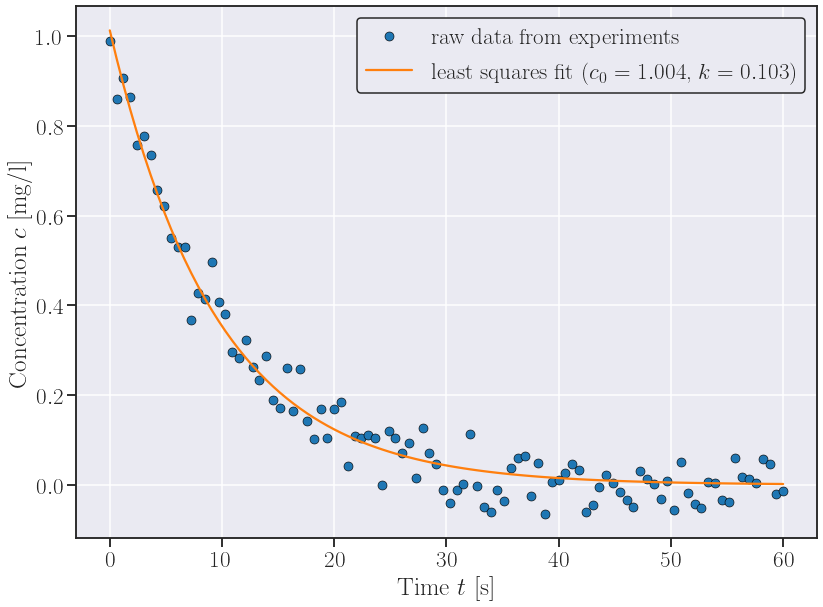

In [48]:
opt_parameters_from_ml_model = create_dict_from_keys_and_values(best_model_pipeline.predict(transform_curve(df_experiment))[0])

label = "prediction from best regressor ("
label += create_plot_label_from_dict(opt_parameters_from_ml_model) + ')'

plot_parameter_ml_model = {"label": label,
                           "save_name": "compare-raw-data-ml-regressor"}      

plot_raw_data_and_analytic_model(opt_parameters_from_ml_model, **plot_parameter_ml_model)

### Plot learning curves

In [62]:
def plot_learning_curves(reg_model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    epochs = np.linspace(50, len(X_train), 10, dtype=int)
    for epoch in epochs:
        reg_model.fit(X_train[:epoch], y_train[:epoch])
        y_train_predict = reg_model.predict(X_train[:epoch])
        y_val_predict = reg_model.predict(X_val[:epoch])
        train_errors.append(mean_squared_error(y_train_predict, y_train[:epoch]))
        val_errors.append(mean_squared_error(y_val_predict, y_val[:epoch]))
    fig, ax = plotStyle.create_figure()
    plt.plot(epochs, np.sqrt(train_errors), 'o', label='error on training data')
    plt.plot(epochs, np.sqrt(val_errors), 's', label='error on validation data')
    plt.xlabel(plotLabels.epochs)
    plt.ylabel(plotLabels.rmse)
    plt.legend()

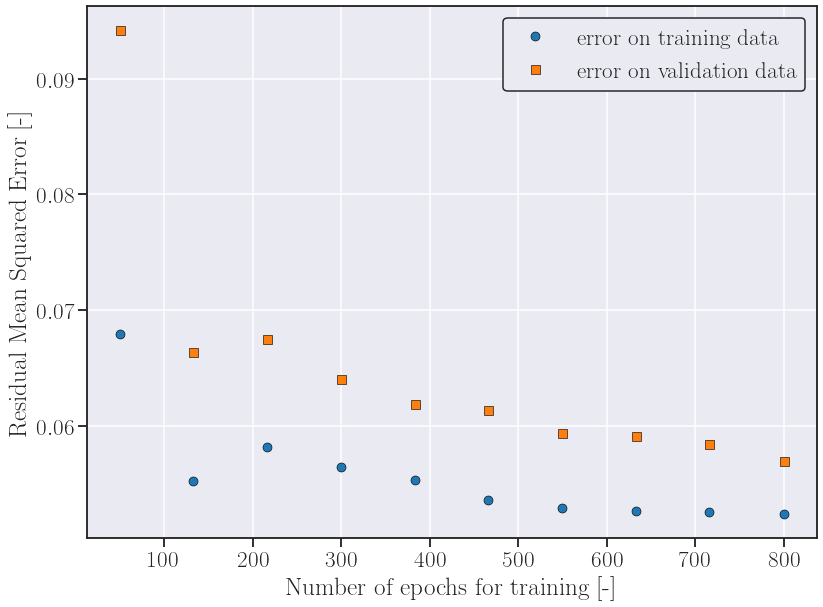

In [63]:
plot_learning_curves(best_model_pipeline.best_estimator_, curves, targets)

## To do
* Contact the **noDataScienceCompany** and present the current state of the project
* Ask for more details regarding their simulations
* Implement simulations and create labled data
* Fit and validate ML model 
* Present findings and opportunities to customer

# Neural Network approach

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.callbacks
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

## Model setup

A flexible function to create a Neural Network (NN) with two hidden layers is presented in the following. The number of neurons per hidden layer can be adjusted among other parameters, e.g. the learning rate.

In [ ]:
def build_keras_model(num_input=202, num_output=2, act='relu', learning_rate=0.001, dropout_rate=0.2, hidden_layer_size_1=50, hidden_layer_size_2=25):  
    model = keras.Sequential()
    model.add(layers.Dropout(dropout_rate, input_shape=(num_input,)))
    model.add(layers.Dense(hidden_layer_size_1, activation=act))
    model.add(layers.Dense(hidden_layer_size_2, activation=act))
    model.add(layers.Dense(num_output))

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

In the following, a predefined amount of hyperparameters are optimized through Scikit-Learn class ``GridSearchCV``. To this end, the Keras model needs to be wrapped as a Scikit-Learn regressor through:

In [ ]:
# pass in fixed parameters num_input and num_output
NN_reg = KerasRegressor(build_fn = build_keras_model,
                        num_input = NUM_DATAPOINTS*NUM_VARS,
                        num_output = NUM_VARS)

## Train Neural Network and optimize hyperparameters

Constant fit parameters, ``fit_params``, for the training process are defined, while the grid search parameters are specified through ``params_grid``. The grid search is performed across all combinations. 

In [ ]:
# Set fixed parameters for the training process.
# Note these parameters could also be treated as 
# variable hyperparameters in the grid search.

fit_params = {'NN__batch_size': 100,
              'NN__verbose': 0,
              'NN__validation_split': 0.2}


# grid search parameters:

params_grid = [{'num_transformations': [numeric_transformer_2],
               'NN': [NN_reg],
               'NN__epochs': [500, 1000],
               'NN__hidden_layer_size_1': [50, 100],
               'NN__hidden_layer_size_2': [50, 100]}]

For convenience, the data transformation and the estimator are combined in a pipeline. Finally the grid search is initialized and fitted to the generated training data. 

In [ ]:
NN_pipe = Pipeline(steps=[('num_transformations', numeric_transformer_2), 
                          ('NN', NN_reg)])

best_NN_pipeline = GridSearchCV(NN_pipe, 
                                param_grid = params_grid,
                                scoring='neg_mean_squared_error', 
                                cv=3,
                                n_jobs=-1)

best_NN_pipeline.fit(X_train, y_train, **fit_params)

The results of the best NN found by the grid search read:

In [ ]:
print("\n\n#---------------- Best Data Pipeline found in GridSearchCV  ----------------#\n\n", best_NN_pipeline.best_estimator_[0])
print("\n\n#---------------- Best Neural Network found in GridSearchCV  ----------------#\n\n")
print('Parameters:')
for param, value in best_NN_pipeline.best_params_.items():
    print('\t{}: {}'.format(param, value))
print("\n\n#---------------- Best Estimator's average score on CV (validation set) ----------------#\n\n", best_NN_pipeline.best_score_)

## Model evaluation

Again, the RMSEs are computed on the training and test data. Finally, the model parameters for the stress-strain curve analyzed in the beginning are predicted with the Neural Network.  

In [ ]:
y_train_predict = best_NN_pipeline.predict(X_train)
y_test_predict = best_NN_pipeline.predict(X_test)

In [ ]:
mae_train = mean_absolute_error(y_train, y_train_predict, multioutput='raw_values')
r2_train = r2_score(y_train, y_train_predict, multioutput='raw_values')

mae_test = mean_absolute_error(y_test, y_test_predict, multioutput='raw_values')
r2_test = r2_score(y_test, y_test_predict, multioutput='raw_values')

In [ ]:
print("mae_train:", mae_train, "; r2_train:", r2_train)
print("mae_test:", mae_test, "; r2_test:", r2_test)

In [ ]:
popt_NN = best_NN_pipeline.predict(concentration_evolution_curve_transformed)

In [ ]:
popt_NN_dict = create_dict_from_keys_and_values(popt_NN)

label = 'prediction NN ('
for key in fit_parameter_names:
    label += "${} = {:.2f}$".format(key, popt_NN_dict[key])
    label += ", "
label = label[:-2] + (')')

In [ ]:
plot_parameter = {"label": label,
                  "save_name": "compare-raw-data-NN-prediction"}

In [ ]:
plot_raw_data_and_analytic_model(popt_NN_dict, **plot_parameter)